In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import re
import ujson
from collections import namedtuple
import multiprocessing as mp
import tqdm as tq
import sklearn.svm as svm
import sklearn.metrics as sm
from random import shuffle
import random
from IPython.display import HTML
import hyperopt as hop
import time
import math
import annoy
import pprint
import json

import gensim.models as gm
import gensim.corpora as gc
import gensim.matutils as gh

%pylab inline

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Baseline

In [2]:
def extract_user_id_with_cat(user_json):
    cat = -user_json["category"]["int"] + 2
    
    vid = user_json.get("vid")
    if vid != "":
        return vid, cat
    
    email = user_json.get("email")
    if email is not None:
        return email["string"], cat
    
    okid = user_json.get("okid")
    if okid is not None:
        return okid["string"], cat
    
    vkid = user_json.get("vkid")
    if vkid is not None:
        return vkid["string"], cat
    
    mmid = user_json.get("mmid")
    if mmid is not None:
        return mmid["string"], cat
    
    raise ValueError(ujson.dumps(user_json))
    
print extract_user_id_with_cat(ujson.loads('{"vid":"261a4bcb1","okid":null,"email":{"string":"zzee"},"vkid":null,"category":{"int":1},"start":null,"end":null,"mmid":null}'))
print extract_user_id_with_cat(ujson.loads('{"vid":"","okid":null,"email":{"string":"abcd"},"vkid":null,"category":{"int":1},"start":null,"end":null,"mmid":null}'))
print extract_user_id_with_cat(ujson.loads('{"vid":"","okid":null,"email":null,"vkid":null,"category":{"int":1},"start":null,"end":null,"mmid":{"string":"xyz"}}'))

(u'261a4bcb1', 1)
(u'abcd', 1)
(u'xyz', 1)


In [3]:
# n_base = 139922
n_base = 30000
m_base = 300

X = np.zeros((n_base, m_base))
Y = np.zeros(n_base)

features_ind_base = dict([("SVD_%d" % i, i) for i in xrange(m_base)])

with open('/Users/anokhin/Desktop/express/base.txt') as bf:
    for i, line in tq.tqdm_notebook(enumerate(bf), total=n_base):
        if i >= n_base:
            print "Finished reading %d baseline user-features" % n_base
            break
        
        line_json = ujson.loads(line)
        
        Y[i] = extract_user_id_with_cat(line_json["key"])[1]
        
        features_json = line_json["value"]["features"]
        for f in features_json:
            X[i, features_ind_base[f["feature_id"]]] = f["value"]["double"]       
            
is_train = np.random.random(n_base) <= 0.75
X_train = X[is_train]
Y_train = Y[is_train]

X_test = X[~is_train]
Y_test = Y[~is_train]

Finished reading 30000 baseline user-features



## Top 1000

In [4]:
# n_top_1000 = 137387
n_top_1000 = 30000
m_top_1000 = 1000
features_ind_top_1000 = {}

U = np.zeros((n_top_1000, m_top_1000))
V = np.zeros(n_top_1000)

with open('/Users/anokhin/Desktop/express/top_1000.txt') as t1000:
    for i, line in tq.tqdm_notebook(enumerate(t1000), total=n_top_1000):
        if i >= n_top_1000:
            print "Finished reading %d top 1000 user-features" % n_top_1000
            break
        
        line_json = ujson.loads(line)
        
        V[i] = extract_user_id_with_cat(line_json["key"])[1]
        
        features_json = line_json["value"]["features"]
        for f in features_json:
            feature_id = f["feature_id"]
            if feature_id not in features_ind_top_1000:
                features_ind_top_1000[feature_id] = len(features_ind_top_1000)
            U[i, features_ind_top_1000[feature_id]] = f["value"]["double"]
            
is_train = np.random.random(n_top_1000) <= 0.75
U_train = U[is_train]
V_train = V[is_train]

U_test = U[~is_train]
V_test = V[~is_train]

Finished reading 30000 top 1000 user-features



## Doc2Vec

In [5]:
# n_cs = 82931
n_cs = 10000

features_ind_cs = {}

black_list_set = set([w.strip() for w in open('/Users/anokhin/Desktop/express/bl.txt')])

def tokenize(url, black_list_set=black_list_set):
    tokenizer_regex = re.compile("[/\\._\\-]")
    numbers_regex = re.compile("\d{1,}")
    tokens = tokenizer_regex.split(url.lower())
    for token in tokens:
        if len(token) <= 3:
            continue
        if token in black_list_set:
            continue
        if numbers_regex.search(token) is not None:
            continue
        
        yield token
        
docs = []
UserDocument = namedtuple('UserDocument', 'words cat tags split')

with open('/Users/anokhin/Desktop/express/cs.txt') as cf:
    for i, line in tq.tqdm_notebook(enumerate(cf), total=n_cs):
        if i >= n_cs:
            print "Finished reading %d clickstream user-features" % n_cs
            break
        
        features_str = line.strip().split("\t")[1]
        words = []
        for session in features_str.split(">>"):
            prev_tokens = []
            for url in session.split("->"):
                curr_tokens = list(tokenize(url))
                if not curr_tokens or curr_tokens == prev_tokens:
                    continue                
                words.extend(curr_tokens)
                prev_tokens = curr_tokens
                
        uid, cat = extract_user_id_with_cat(ujson.loads(line.split("\t")[0]))
                
        if not words or len(words) < 2:
            print "WARN: text for %d-th user '%s' is empty!" % (i, uid)
            continue
            
        docs.append(UserDocument(words, cat, [uid], 'train' if np.random.random() <= 0.75 else 'test'))
                
train_docs = [doc for doc in docs if doc.split == 'train']
test_docs = [doc for doc in docs if doc.split == 'test']

print('%d docs: %d train-sentiment, %d test-sentiment' % (len(docs), len(train_docs), len(test_docs)))



WARN: text for 139-th user '2ee042682' is empty!
WARN: text for 155-th user '2f8b9569b' is empty!
WARN: text for 163-th user '2ffe991e8' is empty!
WARN: text for 168-th user '303d0a390' is empty!
WARN: text for 213-th user '32a414fa1' is empty!
WARN: text for 232-th user '33611a18e' is empty!
WARN: text for 355-th user '38eb5bcc0' is empty!
WARN: text for 423-th user '3c1d3f3e3' is empty!
WARN: text for 471-th user '3e94ea080' is empty!
WARN: text for 477-th user '3eb44cb86' is empty!
WARN: text for 478-th user '3eb4ad3d5' is empty!
WARN: text for 573-th user '41b17f60f' is empty!
WARN: text for 610-th user '431e8bed1' is empty!
WARN: text for 658-th user '44571571b' is empty!
WARN: text for 717-th user '46d5ccb65' is empty!
WARN: text for 764-th user '555fcdd' is empty!
WARN: text for 809-th user '8321f84e' is empty!
WARN: text for 873-th user '299245d0e' is empty!
WARN: text for 895-th user '2b42c3270' is empty!
WARN: text for 999-th user '301d2e341' is empty!
WARN: text for 1010-th 

In [10]:
cores = mp.cpu_count()
assert gm.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

doc2vec1 = gm.Doc2Vec(dm=1, dm_mean=1, size=m_base, window=10, negative=5, hs=0, min_count=2, workers=cores)
doc2vec1.build_vocab(train_docs)

doc2vec2 = gm.Doc2Vec(dm=1, dm_mean=1, size=500, window=10, negative=5, hs=0, min_count=2, workers=cores, iter=10)
doc2vec2.reset_from(doc2vec1)

In [11]:
shuffle(train_docs)

# Train model 1
doc2vec1.train(train_docs)

Z_1_train = np.array([doc2vec1.docvecs[td.tags[0]] for td in train_docs])
V_1_train = np.array([td.cat for td in train_docs])

Z_1_test = np.array([doc2vec1.infer_vector(td.words) for td in test_docs])
V_1_test = np.array([td.cat for td in test_docs])

print "D2V1 Train set: %d x %d, Test set: %d x %d" % (Z_1_train.shape[0], Z_1_train.shape[1], Z_1_test.shape[0], Z_1_test.shape[1])

# Train model 2
doc2vec2.train(train_docs)

Z_2_train = np.array([doc2vec2.docvecs[td.tags[0]] for td in train_docs])
V_2_train = np.array([td.cat for td in train_docs])

Z_2_test = np.array([doc2vec2.infer_vector(td.words) for td in test_docs])
V_2_test = np.array([td.cat for td in test_docs])
print "D2V2 Train set: %d x %d, Test set: %d x %d" % (Z_2_train.shape[0], Z_2_train.shape[1], Z_2_test.shape[0], Z_2_test.shape[1])


D2V1 Train set: 7318 x 300, Test set: 2498 x 300
D2V2 Train set: 7318 x 500, Test set: 2498 x 500


In [12]:
word_models = [doc2vec1, doc2vec2]

while True:
    word = random.choice(word_models[0].index2word)
    if word_models[0].vocab[word].count > 10:
        break

similars_per_model = [str(model.most_similar(word, topn=20)).replace('), ','),<br>\n') for model in word_models]
similar_table = ("<table><tr><th>" +
    "</th><th>".join([str(model) for model in word_models]) + 
    "</th></tr><tr><td>" +
    "</td><td>".join(similars_per_model) +
    "</td></tr></table>")
print("most similar words for '%s' (%d occurences)" % (word, word_models[0].vocab[word].count))
HTML(similar_table)

most similar words for 'traht' (47 occurences)


"Doc2Vec(dm/m,d300,n5,w10,mc2,t4)","Doc2Vec(dm/m,d500,n5,w10,mc2,t4)"
"[('tariffs', 0.8764625191688538), ('linzkurier', 0.8588553071022034), ('hdclub', 0.8565694093704224), ('bizneslab', 0.8562290668487549), ('biblprog', 0.8548899292945862), ('ophtalmix', 0.8520234823226929), ('univega', 0.8512521982192993), ('britanka', 0.8491356372833252), ('totto', 0.8466278910636902), ('powermemory', 0.8460444211959839), ('serverom', 0.8455876708030701), ('citizen', 0.8440148830413818), ('cheburechnaya', 0.8439863920211792), ('clubchat', 0.8438037633895874), ('khosting', 0.8405240774154663), ('metrah', 0.8399929404258728), ('yesterday', 0.8384225368499756), ('cdma', 0.8364397287368774), ('cultin', 0.8348317742347717), ('prodaj', 0.8347176313400269)]","[('winhunters', 0.8361640572547913), ('clbv', 0.8304115533828735), ('tigrovoj', 0.81261146068573), ('titans', 0.8035365343093872), ('cashstream', 0.8019388914108276), ('podmoskovnyj', 0.795358419418335), ('russiateam', 0.7832990884780884), ('perepelov', 0.778820812702179), ('shkure', 0.7713858485221863), ('levoberezhnyjj', 0.7710723876953125), ('dghastin', 0.767819344997406), ('leonard', 0.7672147750854492), ('antiplagiat', 0.7649421095848083), ('timberleyk', 0.7645356059074402), ('obektiva', 0.7644236087799072), ('dghessika', 0.7641836404800415), ('pareny', 0.7630859017372131), ('kartofelnye', 0.7619447708129883), ('starjo', 0.7614225149154663), ('wilgood', 0.761360228061676)]"


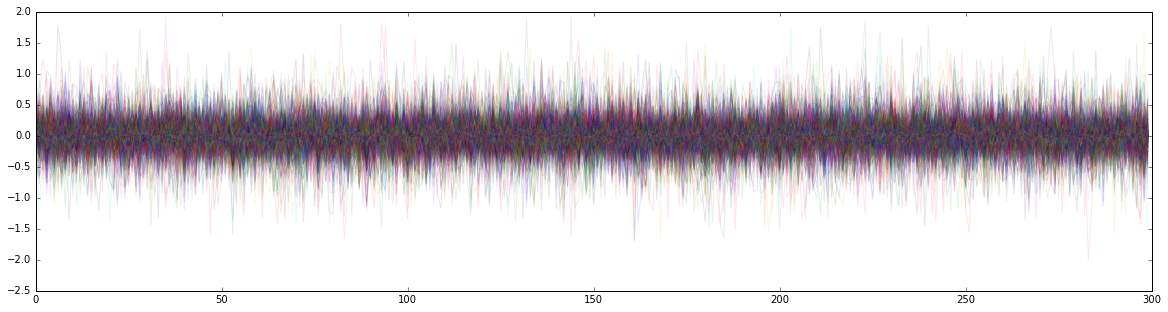

In [13]:
Z_1_orig = np.array([doc2vec1.docvecs[td.tags[0]] for td in train_docs])
Z_1_pred = np.array([doc2vec1.infer_vector(td.words) for td in train_docs])

pl.figure(figsize=(20, 5))
for i in xrange(1000):
    z_orig = Z_1_orig[i]
    z_pred = Z_1_pred[i]
    pl.plot(range(m_base), (z_orig - z_pred), alpha=0.1)
pl.show()

### Выводы
doc2vec не работает для ЛА

## SVD

In [14]:
from six import iteritems

train_texts = [td.words for td in train_docs]
test_texts = [td.words for td in test_docs]

dictionary = gc.Dictionary(train_texts)
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(once_ids)
dictionary.compactify()
print dictionary

train_corpus = [dictionary.doc2bow(text) for text in train_texts]
print len(train_corpus)
test_corpus = [dictionary.doc2bow(text) for text in test_texts]
print len(test_corpus)

Dictionary(79107 unique tokens: [u'biysk', u'sozhgli', u'boyarskoi', u'vseinet', u'zhivotnyje']...)
7318
2498


In [15]:
V_train = np.array([td.cat for td in train_docs])
V_test = np.array([td.cat for td in test_docs])

print V_train.shape, V_test.shape

(7318,) (2498,)


In [18]:
%%time

lsi = gm.lsimodel.LsiModel(corpus=train_corpus, id2word=dictionary, num_topics=300)

[(0,
  u'-0.776*"drom" + -0.288*"auto" + -0.222*"avtomobili" + -0.195*"spec" + -0.157*"toyota"'),
 (1,
  u'0.530*"fotostrana" + -0.323*"drom" + 0.316*"odezhda" + 0.251*"love" + 0.236*"obuv"'),
 (2,
  u'0.680*"fotostrana" + -0.322*"avtomobili" + 0.248*"love" + -0.206*"odezhda" + 0.190*"drom"'),
 (3,
  u'-0.810*"love" + 0.298*"fotostrana" + 0.244*"odezhda" + -0.195*"search" + -0.192*"avtomobili"'),
 (4,
  u'0.591*"avtomobili" + -0.439*"odezhda" + -0.320*"obuv" + -0.301*"love" + 0.237*"fotostrana"')]
CPU times: user 54.6 s, sys: 3.91 s, total: 58.5 s
Wall time: 39.9 s


In [23]:
print pprint.pformat(lsi.print_topics(10, 8))

[(0,
  u'-0.776*"drom" + -0.288*"auto" + -0.222*"avtomobili" + -0.195*"spec" + -0.157*"toyota" + -0.138*"truck" + -0.107*"catalog" + -0.100*"moskva"'),
 (1,
  u'0.530*"fotostrana" + -0.323*"drom" + 0.316*"odezhda" + 0.251*"love" + 0.236*"obuv" + 0.221*"avtomobili" + 0.219*"moskva" + 0.175*"aksessuary"'),
 (2,
  u'0.680*"fotostrana" + -0.322*"avtomobili" + 0.248*"love" + -0.206*"odezhda" + 0.190*"drom" + -0.176*"moskva" + 0.157*"user" + -0.156*"obuv"'),
 (3,
  u'-0.810*"love" + 0.298*"fotostrana" + 0.244*"odezhda" + -0.195*"search" + -0.192*"avtomobili" + 0.180*"obuv" + -0.173*"message" + 0.092*"detskaya"'),
 (4,
  u'0.591*"avtomobili" + -0.439*"odezhda" + -0.320*"obuv" + -0.301*"love" + 0.237*"fotostrana" + -0.159*"aksessuary" + -0.143*"detskaya" + 0.132*"oblast"'),
 (5,
  u'0.441*"doma" + 0.414*"dachi" + 0.412*"kottedzhi" + -0.396*"avtomobili" + 0.232*"prodam" + 0.197*"uchastke" + 0.190*"kvartiry" + 0.185*"ulan"'),
 (6,
  u'-0.515*"catalog" + -0.302*"moskva" + -0.257*"wildberries" + 0

## LDA

In [20]:
%%time

lda = gm.ldamodel.LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=300, update_every=1, chunksize=1000, passes=5)

[(213,
  u'0.087*murmansk + 0.039*cards + 0.037*avtomobiley + 0.034*autos + 0.027*portfolio'),
 (143,
  u'0.059*stars + 0.033*cosmo + 0.022*beauty + 0.017*chto + 0.016*novosti'),
 (20, u'0.261*mebel + 0.132*interer + 0.032*divan + 0.029*stoly + 0.026*stol'),
 (221,
  u'0.242*klenmarket + 0.238*equipment + 0.081*inventory + 0.043*kitchen + 0.031*cookware'),
 (83,
  u'0.293*ekaterinburg + 0.073*talk + 0.068*girls + 0.036*spool + 0.028*otvety')]
CPU times: user 17min 48s, sys: 1min 56s, total: 19min 45s
Wall time: 19min 55s


In [24]:
print pprint.pformat(lda.print_topics(10, 8))

[(267,
  u'0.104*vladimir + 0.096*platya + 0.083*plate + 0.060*session + 0.056*amic + 0.055*wssp + 0.039*optom + 0.032*mailbox'),
 (206,
  u'0.418*katalog + 0.088*internet + 0.031*truba + 0.027*ruchnye + 0.020*kremenchug + 0.019*sibmama + 0.019*posting + 0.018*boat'),
 (171,
  u'0.045*amurskaya + 0.045*pegast + 0.043*blagoveschensk + 0.043*kanobu + 0.032*bulletins + 0.031*actual + 0.018*valeriya + 0.018*tehno'),
 (211,
  u'0.171*posts + 0.113*calendar + 0.113*tovarov + 0.078*inmyroom + 0.027*platie + 0.026*nstarikov + 0.026*fedor + 0.022*idej'),
 (142,
  u'0.153*apteka + 0.079*visa + 0.067*vesy + 0.067*zoon + 0.056*vypechki + 0.043*capricorn + 0.034*vesi + 0.032*igrovye'),
 (40,
  u'0.429*feed + 0.303*friends + 0.079*apps + 0.032*guests + 0.027*drive + 0.024*groups + 0.016*gifts + 0.010*settings'),
 (268,
  u'0.034*kinostok + 0.032*face + 0.030*efir + 0.030*videos + 0.023*care + 0.023*mogilev + 0.021*lite + 0.021*television'),
 (183,
  u'0.275*minigames + 0.043*durak + 0.043*iledebeaut

## Evaluation

In [26]:
test_config = [
    ('baseline SVD', X_train, Y_train, X_test, Y_test),
    ('Doc2Vec1', Z_1_train, V_1_train, Z_1_test, V_1_test), 
    ('Doc2Vec2', Z_2_train, V_2_train, Z_2_test, V_2_test),
    ('Top 1000', U_train, V_train, U_test, V_test)
]

N = 10

aucs = np.zeros((N, len(test_config) * 2))

for j in tq.tqdm_notebook(xrange(N)):
    for i, (m, x_train, y_train, x_test, y_test) in enumerate(test_config):
        svc1 = svm.LinearSVC(C=0.01)
        svc1.fit(x_train, y_train)
        y_pred = svc1.decision_function(x_test)
        aucs[j, i] = sm.roc_auc_score(y_test, y_pred)
        
        index = annoy.AnnoyIndex(x_train.shape[1])
        for k, x in enumerate(x_train):
            index.add_item(k, x)
        index.build(10)
        
        y_pred = np.zeros(y_test.shape[0])
        for k, x in enumerate(x_test):
            n_closest_ind = index.get_nns_by_vector(x, 100)
            y_pred[k] = y_train[n_closest_ind].mean()        
        aucs[j, i + len(test_config)] = sm.roc_auc_score(y_test, y_pred)
        
aucs

array([[ 0.79219484,  0.66359998,  0.66336236,  0.7884207 ,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.79180755,  0.66359998,  0.66336193,  0.78869852,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.79304624,  0.66359998,  0.66336236,  0.79002119,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.78990889,  0.66359998,  0.66336236,  0.78943693,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.7905311 ,  0.66359998,  0.66336236,  0.78961229,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.79188295,  0.66359998,  0.66336236,  0.78878383,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.7927561 ,  0.66359998,  0.6633615 ,  0.79001484,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.79351464,  0.66359998,  0.6633615 ,  0.79014849,  0.73788913,
         0.67054957,  0.67340352,  0.73633785],
       [ 0.79295382,  0.66359998

(10, 8)


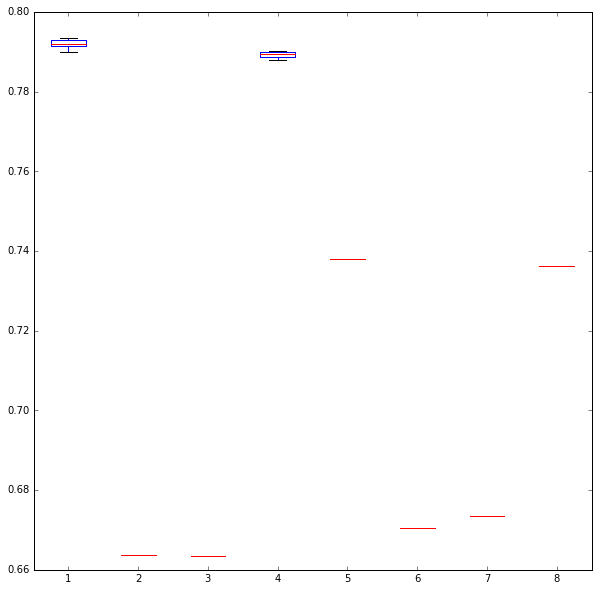

In [27]:
aucs1 = aucs

print aucs1.shape

pl.figure(figsize=(10, 10))
pl.boxplot(aucs1)
pl.show()

In [17]:
space = [
    hop.hp.choice('preproc_type',
        [
            {'type': 'base'},
#             {'type': 'd2v', 'n': hop.hp.quniform('base_n', 100, 1000, 100)},
            {'type': 'lsi', 'n': hop.hp.quniform('lsi_n', 200, 1200, 100)},
            {'type': 'lda', 'n': hop.hp.quniform('lda_n', 300, 1200, 300)}
        ]),
    hop.hp.choice('classifier_type', 
        [
            {'type': 'linear_svm', 'C': hop.hp.loguniform('svm_C', -5, 5)},
            {'type': 'annoy', 'k': hop.hp.qloguniform('annoy_k', 0, 6, 1), 'metric': hop.hp.choice('annoy_metric', ['euclidean', 'angular'])}
        ])
]

ldas = {}
lsis = {}

def objective(args):
    preproc, clf = args
    
    if preproc['type'] == "base":
        X_tr = X_train
        Y_tr = Y_train

        X_te = X_test
        Y_te = Y_test
    elif preproc['type'] == "d2v":
        d2v = gm.Doc2Vec(dm=1, dm_mean=1, size=int(preproc["n"]), window=10, negative=5, hs=0, min_count=2, workers=cores, iter=10)
        d2v.build_vocab(train_docs)
        doc2vec2.train(train_docs)

        X_tr = np.array([d2v.docvecs[td.tags[0]] for td in train_docs])
        Y_tr = np.array([td.cat for td in train_docs])

        X_te = np.array([d2v.infer_vector(td.words) for td in test_docs])
        Y_te = np.array([td.cat for td in test_docs])
    elif preproc['type'] == "lsi":
        n = int(preproc['n'])
        if n not in lsis:
            print "Computing LSI for n=%d" % n
            lsi = gm.lsimodel.LsiModel(corpus=train_corpus, id2word=dictionary, num_topics=n)
            X_lsi_train = gh.corpus2dense(lsi[train_corpus], n).T
            X_lsi_test = gh.corpus2dense(lsi[test_corpus], n).T
            lsis[n] = (X_lsi_train, X_lsi_test)
        X_tr, X_te = lsis[n]
        Y_tr = V_train        
        Y_te = V_test
    elif preproc['type'] == "lda":
        n = int(preproc['n'])
        if n not in ldas:
            print "Computing LDA for n=%d" % n
            lda = gm.ldamodel.LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=n, update_every=1, chunksize=1000, passes=15)
            X_lda_train = gh.corpus2dense(lda[train_corpus], n).T
            X_lda_test = gh.corpus2dense(lda[test_corpus], n).T
            ldas[n] = (X_lda_train, X_lda_test)
        X_tr, X_te = ldas[n]
        Y_tr = V_train
        Y_te = V_test                       
    else:
        return {
            'loss': 1,
            'status': hop.STATUS_FAIL,        
            'eval_time': time.time(),
            'message': 'preproc not found'
        }
        
    if clf['type'] == 'linear_svm':
        svc = svm.LinearSVC(C=clf['C'])
        svc.fit(X_tr, Y_tr)
        Y_pr = svc.decision_function(X_te)
        loss = 1 - sm.roc_auc_score(Y_te, Y_pr)
    elif clf['type'] == 'annoy':        
        index = annoy.AnnoyIndex(X_tr.shape[1], metric=clf['metric'])
        for k, x in enumerate(X_tr):            
            index.add_item(k, x)
        index.build(10)
        
        Y_pr = np.zeros(Y_te.shape[0])        
        for k, x in enumerate(X_te):            
            n_closest_ind = index.get_nns_by_vector(x, int(clf['k']))
            Y_pr[k] = Y_tr[n_closest_ind].mean()
        loss = 1 - sm.roc_auc_score(Y_te, Y_pr)
    else:
        return {
            'loss': 1,
            'status': hop.STATUS_FAIL,        
            'eval_time': time.time(),
            'message': 'classifier not found'
        }
        
    return {
        'loss': loss,
        'status': hop.STATUS_OK,        
        'eval_time': time.time()        
        }

trials = hop.Trials()
hop.fmin(objective, space, algo=hop.tpe.suggest, max_evals=2000, trials=trials)

Computing LDA for n=600
Computing LDA for n=900
Computing LSI for n=300
Computing LDA for n=300
Computing LSI for n=500
Computing LDA for n=1200
Computing LSI for n=800
Computing LSI for n=1200
Computing LSI for n=900
Computing LSI for n=1000
Computing LSI for n=600
Computing LSI for n=700
Computing LSI for n=1100
Computing LSI for n=200
Computing LSI for n=400


{'classifier_type': 0, 'preproc_type': 0, 'svm_C': 0.05533478539327395}

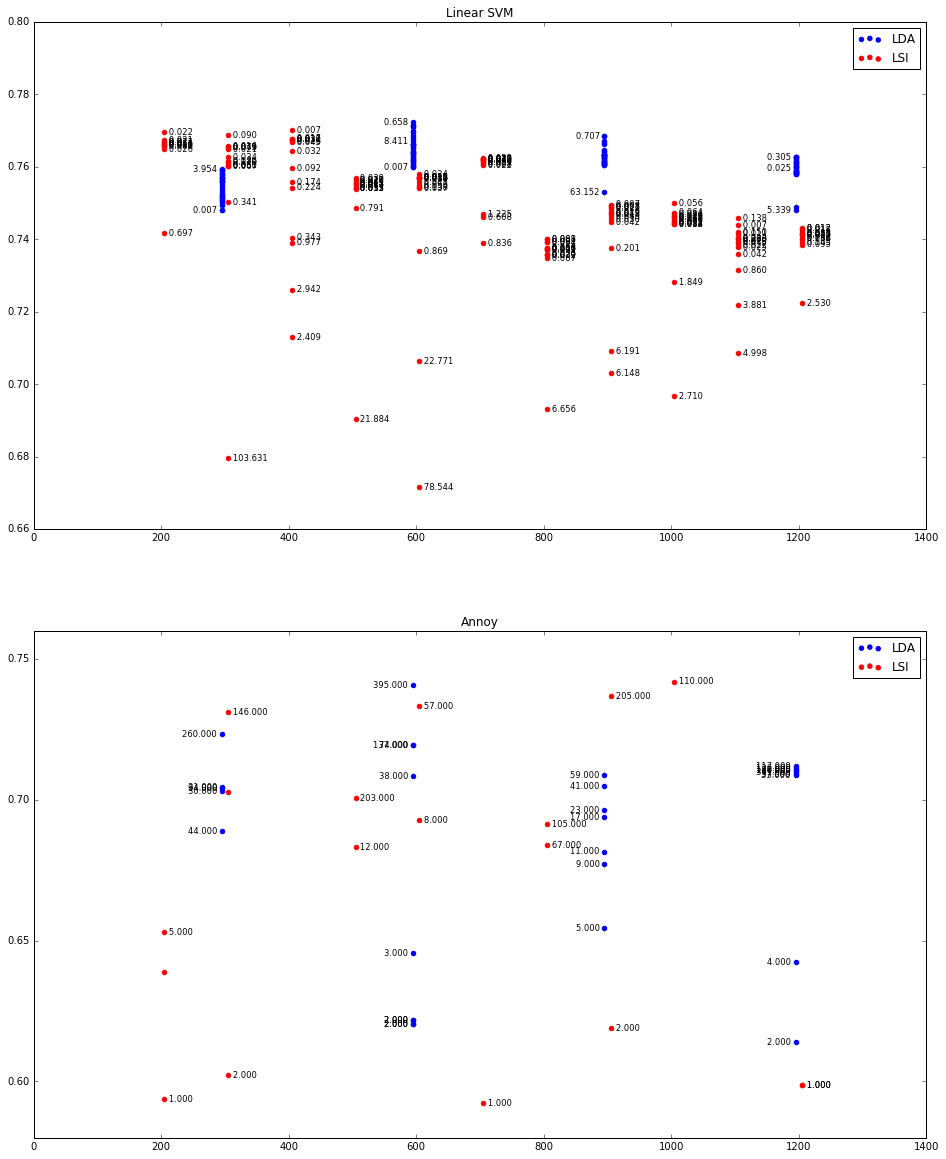

In [18]:
def extract_data(trial):
    def get_or_none(i, l):        
        if len(l) > i:
            return l[i]
        else:
            return None
    
    data = {
        'clf': ['linear_svm', 'annoy'][trial['misc']['vals']['classifier_type'][0]],
        'svm_c': get_or_none(0, trial['misc']['vals']['svm_C']),
        'annoy_metric': get_or_none(0, trial['misc']['vals']['annoy_metric']),
        'annoy_k': get_or_none(0, trial['misc']['vals']['annoy_k']),
        'preproc': ['base', 'lsi', 'lda'][trial['misc']['vals']['preproc_type'][0]],
        'lda_n': get_or_none(0, trial['misc']['vals']['lda_n']),
        'lsi_n': get_or_none(0, trial['misc']['vals']['lsi_n']),
        'auc': 1 - trial['result']['loss']
    }
    return data
    
    
df_trials = pd.DataFrame([extract_data(t) for t in trials])

pl.figure(figsize=(16, 20))

pl.subplot(2, 1, 1)
df_slice = df_trials[(df_trials.preproc == 'lda') & (df_trials.clf == 'linear_svm')]
pl.scatter(df_slice.lda_n - 5, df_slice.auc, color='blue', label='LDA')
for i, row in df_slice.iterrows():
    if i % 50 == 0 or row.auc == df_slice.auc[df_slice.lda_n == row.lda_n].max() or row.auc == df_slice.auc[df_slice.lda_n == row.lda_n].min():
        pl.annotate("%.3f   " % row.svm_c, (row.lda_n, row.auc), size='small', ha='right', va='center')

df_slice = df_trials[(df_trials.preproc == 'lsi') & (df_trials.clf == 'linear_svm')]
pl.scatter(df_slice.lsi_n + 5, df_slice.auc, color='red', label='LSI')
for i, row in df_slice.iterrows():
    if i % 1 == 0 or row.auc == df_slice.auc[df_slice.lsi_n == row.lsi_n].max() or row.auc == df_slice.auc[df_slice.lsi_n == row.lsi_n].min():
        pl.annotate("   %.3f" % row.svm_c, (row.lsi_n, row.auc), size='small', ha='left', va='center')

pl.legend()
pl.title('Linear SVM')

pl.subplot(2, 1, 2)
df_slice = df_trials[(df_trials.preproc == 'lda') & (df_trials.clf == 'annoy')]
pl.scatter(df_slice.lda_n - 5, df_slice.auc, color='blue', label='LDA')
for i, row in df_slice.iterrows():
    if i % 1 == 0 or row.auc == df_slice.auc[df_slice.lda_n == row.lda_n].max() or row.auc == df_slice.auc[df_slice.lda_n == row.lda_n].min():
        pl.annotate("%.3f   " % row.annoy_k, (row.lda_n, row.auc), size='small', ha='right', va='center')

df_slice = df_trials[(df_trials.preproc == 'lsi') & (df_trials.clf == 'annoy')]
pl.scatter(df_slice.lsi_n + 5, df_slice.auc, color='red', label='LSI')
for i, row in df_slice.iterrows():
    if i % 4 == 0 or row.auc == df_slice.auc[df_slice.lsi_n == row.lsi_n].max() or row.auc == df_slice.auc[df_slice.lsi_n == row.lsi_n].min():
        pl.annotate("   %.3f" % row.annoy_k, (row.lsi_n, row.auc), size='small', ha='left', va='center')

pl.legend()
pl.title('Annoy')

pl.show()